In [1]:
## this notebook will be used for experimenting neural collaborative filtering on the anime data 
"""In this notebook, I tried to mimic Neural Collaborative Filtering(NCF) on Anime dateset.
NCF is composed of one matrix factorization side(GMF) and a multi-layer perceptron side.(MLP)
As final layer both side has been concatenated using a concatenation layer.
In general, both user and item features are embedded and sub-dimensions of the 
feature embeddings were interpreted as latent features. Both GMF and MLP layer
were shared the same embedding vectors.  """

'In this notebook, I tried to mimic Neural Collaborative Filtering(NCF) on Anime dateset.\nNCF is composed of one matrix factorization side(GMF) and a multi-layer perceptron side.(MLP)\nAs final layer both side has been concatenated using a concatenation layer.\nIn general, both user and item features are embedded and sub-dimensions of the \nfeature embeddings were interpreted as latent features. Both GMF and MLP layer\nwere shared the same embedding vectors.  '

In [2]:
# !pip install --quiet "dask[complete]"
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd 
import numpy as np 
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding,Flatten
from tensorflow.keras.layers import Multiply,Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical,plot_model

In [4]:
### parameters
embed_dim =16


In [5]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/ua_df.csv',nrows = 3000000)
df = df.drop(columns = ['Unnamed: 0'])
binary_score = np.random.randint(2, size = len(df))
df['binary_score'] = binary_score
df = df.sort_values(by = ['user_id']).reset_index(drop = True)
# train_df, test_df = train_test_split(df, train_size = 0.8, test_size=0.2, random_state=42)

In [6]:
user_num = len(df['user_id'].unique())
anime_num = len(df['anime_id'].unique())
print('number of unique users', user_num)
print('number of unique animes', anime_num)

number of unique users 107374
number of unique animes 109


In [7]:
print(np.max(df['user_id']))
""" Maximum value for the user_id and the anime_id is larger than the number 
 of unique users and unique animes. This situation can cause higher loss values
 or higher upper bound and ambiguity for sorfmax functions. In addition, vectorization
 process can take much more time. Therefore , I will create monotonic values
 and original values can be mapped from those values."""

7251737


' Maximum value for the user_id and the anime_id is larger than the number \n of unique users and unique animes. This situation can cause higher loss values\n or higher upper bound and ambiguity for sorfmax functions. In addition, vectorization\n process can take much more time. Therefore , I will create monotonic values\n and original values can be mapped from those values.'

In [8]:
uniq_user_ids = df['user_id'].unique()
user_2mapped = {i:j for i,j in enumerate(uniq_user_ids) }
mapped_2user = {j:i  for i,j in enumerate(uniq_user_ids)}


uniq_anime_ids = df['anime_id'].unique()
anime_2mapped = {i:j for i,j in enumerate(uniq_anime_ids) }
mapped_2anime = {j:i  for i,j in enumerate(uniq_anime_ids)}

In [9]:
user_id_mapped = df['user_id'].map(mapped_2user)
anime_id_mapped = df['anime_id'].map(mapped_2anime)
mapped_df = pd.DataFrame({'user_id' : user_id_mapped ,
                          'anime_id' : anime_id_mapped,
                          'score' : df['binary_score']
                          })

In [10]:
train_df, test_df = train_test_split(mapped_df, train_size = 0.8, test_size=0.2, random_state=42)

In [11]:
train_df

,user_id,anime_id,score
2330946,79448,59,0
2776943,97108,73,1
1999522,66980,50,1
133245,3994,18,1
1431595,47437,16,1
...,...,...,...
1692743,56275,49,1
2356330,80427,53,1
2229084,75516,25,1
2768307,96765,93,1


In [12]:
user_input = tf.keras.Input(shape = (1), name = 'user_input')
anime_input = tf.keras.Input(shape  = (1), name  ='anime_input')

user_emb_layer = Embedding(user_num+2,embed_dim,name='user_embeddings')(user_input)
anime_emb_layer = Embedding(anime_num+2,embed_dim,name='anime_embeddings')(anime_input)
flat_user = Flatten(name = 'user_flatten')(user_emb_layer)
flat_anime = Flatten(name = 'anime_flatten')(anime_emb_layer)


print(flat_user.shape)
print(flat_anime.shape)

(None, 16)
(None, 16)


In [13]:
### MLP SIDE
# concat_layer = Concatenate(axis=2, name = 'concat_layer'
#                 )([user_emb_layer,anime_emb_layer])
concat_layer = Concatenate(axis=1, name = 'concat_layer'
                )([flat_user,flat_anime])
print(concat_layer.shape)
mlp_layer_1 = Dense(128, activation='relu',name ='dense_1')(concat_layer)
mlp_layer_2 = Dense(64, activation='relu',name ='dense_2')(mlp_layer_1)
mlp_layer_3 = Dense(32, activation='relu',name ='dense_3')(mlp_layer_2)
mlp_layer_4 = Dense(16, activation='relu',name ='dense_4')(mlp_layer_3)
mlp_layer_5 = Dense(8, activation='relu',name ='dense_5')(mlp_layer_4)

# mlp_model = tf.keras.Model(inputs = [user_input, anime_input], outputs=mlp_layer_5 )
# mlp_model.compile(
#     loss = 'BinaryCrossentropy',
#     optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
#     # optimizer = 'Adam',
#     metrics = 'accuracy'
# )
print(mlp_layer_5.shape)
### MLP SIDE

(None, 32)
(None, 8)


In [14]:
### MLP SIDE
gmf_layer = Multiply( name = 'element_multip_layer'
                )([flat_user,flat_anime])
print('gmf_layer_shape',gmf_layer.shape)
### MLP SIDE

gmf_layer_shape (None, 16)


In [15]:
neuMF_layer =Concatenate(axis=1, name = 'neuMF_layer'
                )([gmf_layer,mlp_layer_5])

neuMF_layer_2 = Dense(8, activation='relu',name ='dense_neuMF_1')(neuMF_layer)
neuMF_layer_3 = Dense(2, activation='sigmoid',name ='dense_neuMF_2')(neuMF_layer_2)
print(neuMF_layer.shape)

(None, 24)


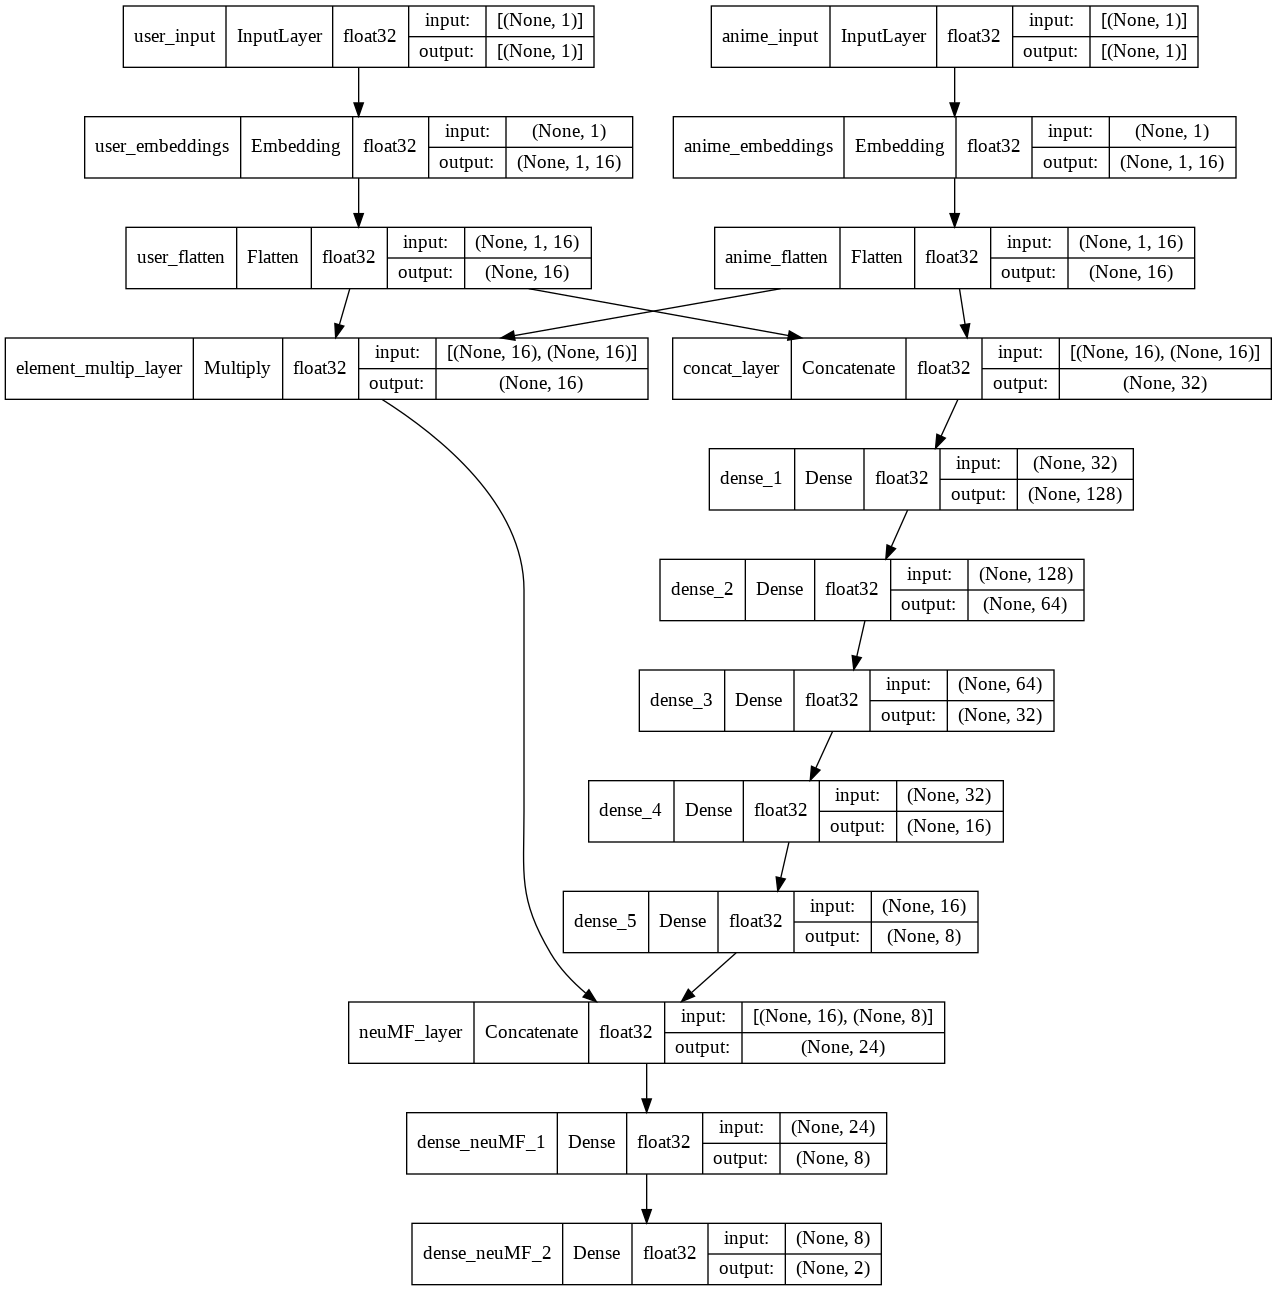

In [16]:
mlp_model = tf.keras.Model(inputs = [user_input, anime_input], outputs=neuMF_layer_3  )
mlp_model.compile(
    loss = 'BinaryCrossentropy',
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
    # optimizer = 'Adam',
    # metrics = 'accuracy'
)

# mlp_model = tf.keras.Model(inputs = [user_input, anime_input], outputs=mlp_layer_5 )
# mlp_model.compile(
#     loss = 'BinaryCrossentropy',
#     optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
#     # optimizer = 'Adam',
#     metrics = 'accuracy'
# )
tf.keras.utils.plot_model(
    mlp_model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    # dpi=96,
    # layer_range=None,
    show_layer_activations=False
)


In [17]:
cat_score = to_categorical(train_df['score'])
cat_score_test = to_categorical(test_df['score'])

In [ ]:
mlp_hist = mlp_model.fit([train_df['user_id'], train_df['anime_id']],
                          cat_score,
                          epochs = 1,
                          validation_split = 0.2)

60000/60000 [==============================] - 269s 4ms/step - loss: 0.6931 - val_loss: 0.6931


In [ ]:
mlp_model.evaluate([test_df['user_id'], test_df['anime_id']],
                          cat_score_test,)

In [ ]:
plt.plot(mlp_hist.history['accuracy'])
plt.plot(mlp_hist.history['val_accuracy'])